In [1]:
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               generate_perturbation_effects)

import torch
import matplotlib.pyplot as plt

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

In [11]:
# generate the binding data (same as usual)
n_genes = 3000

signal = [0.5, 0.5, 0.5, 0.5, 0.5]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for signal_proportion, n_draws in zip(signal, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, signal_proportion))
        
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

perturbation_effects_list = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index, signal_mean=10.0, signal_std=3.0)
                             for tf_index in range(sum(n_sample))]

perturbation_pvalue_list = [generate_pvalues(perturbation_effects)
                            for perturbation_effects in perturbation_effects_list]

# Convert lists to tensors if they are not already
perturbation_effects_tensor = torch.stack(perturbation_effects_list, dim=1)
perturbation_pvalues_tensor = torch.stack(perturbation_pvalue_list, dim=1)

# Ensure perturbation data is reshaped to match [n_genes, n_tfs]
perturbation_effects_tensor = perturbation_effects_tensor.unsqueeze(-1)
perturbation_pvalues_tensor = perturbation_pvalues_tensor.unsqueeze(-1)

# Concatenate along the last dimension to form a [n_genes, n_tfs, 5] tensor
final_data_tensor = torch.cat((binding_data_tensor, perturbation_effects_tensor, perturbation_pvalues_tensor), dim=2)

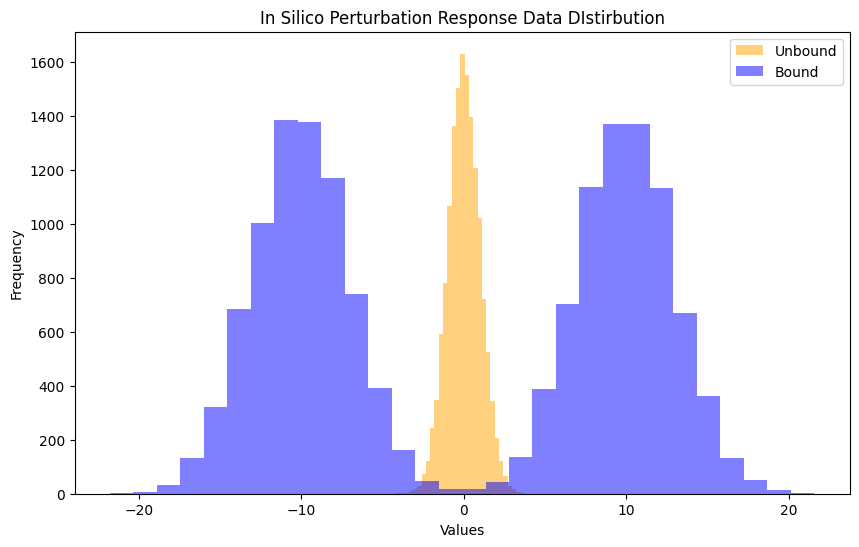

In [12]:
labels = final_data_tensor[:, :, 0].flatten()
noise_perturbation = final_data_tensor[:, :, 3].flatten()[labels == 0]
signal_perturbation = final_data_tensor[:, :, 3].flatten()[labels == 1]

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(noise_perturbation, bins=30, alpha=0.5, label='Unbound', color='orange')
plt.hist(signal_perturbation, bins=30, alpha=0.5, label='Bound', color='blue')
plt.title('In Silico Perturbation Response Data DIstirbution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()